In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
from matplotlib import pyplot as plt
import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/train.csv
./data/test.csv


# Dataset:
Input variables:

   **# bank client data:**
   
   1 - ID : ID of client
   
   2 - age (numeric)
   
   3 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   
   4 - marital : marital status (categorical: "divorced","married","single"; note: "divorced" means divorced or widowed)
   
   5 - education (categorical: "primary","secondary","tertiary,"unknown")
   
   6 - default: has credit in default? (categorical: "no","yes")
   
   7 - balance : has money in account? (numeric)
   
   8 - housing: has housing loan? (categorical: "no","yes")
   
   9 - loan: has personal loan? (categorical: "no","yes")
   
   10 - contact: contact communication type (categorical: "cellular","telephone") 
   
   11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   
   12 - day: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
   
   13 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   
   14 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
   
   15 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)
   
   16 - previous: number of contacts performed before this campaign and for this client (numeric)
   
   17 - poutcome: outcome of the previous marketing campaign (categorical: "failure","unknown","other","success")
   
  
   **Output variable (desired target):**
   
   18 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [3]:
train = pd.read_csv("./data/train.csv", sep=";")
test = pd.read_csv("./data/test.csv", sep=";")

In [4]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [46]:
len(train.columns)

29

# **1.Filling NaN(unknown) Values:**

In [6]:
train.isna().sum() , test.isna().sum()

(age          0
 job          0
 marital      0
 education    0
 default      0
 balance      0
 housing      0
 loan         0
 contact      0
 day          0
 month        0
 duration     0
 campaign     0
 pdays        0
 previous     0
 poutcome     0
 y            0
 dtype: int64,
 age          0
 job          0
 marital      0
 education    0
 default      0
 balance      0
 housing      0
 loan         0
 contact      0
 day          0
 month        0
 duration     0
 campaign     0
 pdays        0
 previous     0
 poutcome     0
 y            0
 dtype: int64)

In [7]:
train.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

* **FILLING UNKNOWN VALUES :**
It's look like dataset has no NaN values but dataset has "unknown" values.

In [8]:
train["job"].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

Filling unknown job values with mode value but also we can fill unknown job values with mode of education degree per job.
So babsically here we are assuming a direct relation between education degree and job. So below we have calculated the probability of a job depending on the education.

In [9]:
eduRatio = pd.DataFrame({'Job' : []})
for i in train["job"].unique():
    eduRatio = eduRatio.append(train[(train["job"] == i)]["education"].value_counts().to_frame().iloc[0] * 100 / train[(train["job"] == i)]["education"].value_counts().sum())
eduRatio["Job"] = train["job"].unique()
eduRatio

,Job,education
tertiary,management,82.480440
secondary,technician,68.829801
tertiary,entrepreneur,46.133154
secondary,blue-collar,55.189067
unknown,unknown,44.097222
secondary,retired,43.462898
secondary,admin.,81.589635
secondary,services,83.220992
tertiary,self-employed,52.754908
secondary,unemployed,55.871067


In [10]:
train.loc[(train.job == "unknown") & (train.education == "secondary"),"job"] = "services"
train.loc[(train.job == "unknown") & (train.education == "primary"),"job"] = "housemaid"
train.loc[(train.job == "unknown") & (train.education == "tertiary"),"job"] = "management"
train.loc[(train.job == "unknown"),"job"] = "blue-collar"

In [11]:
train["job"].value_counts()

blue-collar      9859
management       9497
technician       7597
admin.           5171
services         4225
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1291
student           938
Name: job, dtype: int64

Similarly we can fill all the unknown values in education depending on the job they have. This also will be done according to probabilities we found out above.

In [12]:
train.loc[(train.education == "unknown") & (train.job == "admin."),"education"] = "secondary"
train.loc[(train.education == "unknown") & (train.job == "management"),"education"] = "secondary"
train.loc[(train.education == "unknown") & (train.job == "services"),"education"] = "tertiary"
train.loc[(train.education == "unknown") & (train.job == "technician."),"education"] = "secondary"
train.loc[(train.education == "unknown") & (train.job == "retired"),"education"] = "secondary"
train.loc[(train.education == "unknown") & (train.job == "blue-collar"),"education"] = "secondary"
train.loc[(train.education == "unknown") & (train.job == "housemaid."),"education"] = "primary"
train.loc[(train.education == "unknown") & (train.job == "self-employed"),"education"] = "tertiary"
train.loc[(train.education == "unknown") & (train.job == "student"),"education"] = "secondary"
train.loc[(train.education == "unknown") & (train.job == "entrepreneur"),"education"] = "tertiary"
train.loc[(train.education == "unknown") & (train.job == "unemployed"),"education"] = "secondary"
#REST CAN BE SECONDARY, because secondary is the mode
train.loc[(train.education == "unknown"),"education"] = "secondary"

In [13]:
train["education"].value_counts()

secondary    24794
tertiary     13566
primary       6851
Name: education, dtype: int64

In [14]:
test["education"].value_counts()

secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64

In [15]:
train["default"].value_counts()

no     44396
yes      815
Name: default, dtype: int64

In [16]:
train["housing"].value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

In [17]:
train["contact"].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [18]:
train["contact"].replace(["unknown"],train["contact"].mode(),inplace = True) # I replace unknown contact values with mode value

In [19]:
train["poutcome"].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [20]:
train.drop(columns = ["day","month"],inplace = True)

In [21]:
train["y"].value_counts() #We can see here dataset imbalanced. We are going to augment the data with smote.

no     39922
yes     5289
Name: y, dtype: int64

In [45]:
train.shape

(45211, 29)

# **2.Encoding:**
We need to transform all categorical columns to numeric columns.

In [23]:
#OneHotEncoding of job column
ohe = OneHotEncoder(sparse = False)
train = pd.concat((train , pd.DataFrame(ohe.fit_transform(train["job"].to_frame()),columns = "job_" + np.sort(train["job"].unique()))),axis = 1)
train.drop(columns = ["job"],inplace = True)
#Marital column has 3 values lets apply OneHotEncoding again.
train = pd.concat((train , pd.DataFrame(ohe.fit_transform(train["marital"].to_frame()),columns = "marital_" + np.sort(train["marital"].unique()))),axis = 1)
train.drop(columns = ["marital"],inplace = True)

In [24]:
train.head()

,age,education,default,balance,housing,loan,contact,duration,campaign,pdays,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single
0,58,tertiary,no,2143,yes,no,cellular,261,1,-1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,44,secondary,no,29,yes,no,cellular,151,1,-1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,33,secondary,no,2,yes,yes,cellular,76,1,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,47,secondary,no,1506,yes,no,cellular,92,1,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,33,secondary,no,1,no,no,cellular,198,1,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We can label encode education column.Because its ordinal data.Also we can transform default column yes/no values to 0 and 1

In [25]:
train.loc[(train.education == "tertiary"),"education"] = 2
train.loc[(train.education == "secondary") ,"education"] = 1
train.loc[(train.education == "primary"),"education"] = 0
#Default Column
train.loc[(train.default == "yes"),"default"] = 1
train.loc[(train.default == "no") ,"default"] = 0

In [26]:
train.balance.sort_values() # We have 2 outliner data.We can change their value to new maximum

12909     -8019
15682     -6847
38736     -4057
7413      -3372
1896      -3313
          ...  
41693     71188
42558     81204
43393     81204
26227     98417
39989    102127
Name: balance, Length: 45211, dtype: int64

In [27]:
train.loc[(train.balance > 66721),"balance"] = 66721
#Lets scale balance column.
train["balance"]= train["balance"] / 66721

Housing , loan and contact columns label encoding and dropping duration column

In [28]:
train.loc[(train.housing == "yes"),"housing"] = 1 # housing column label encoding
train.loc[(train.housing == "no") ,"housing"] = 0

#Loan column label encoding
train.loc[(train.loan == "yes"),"loan"] = 1
train.loc[(train.loan == "no") ,"loan"] = 0

#contact column label encoding
train.loc[(train.contact == "telephone"),"contact"] = 1 # 0 means cellular 1 means telephone
train.loc[(train.contact == "cellular") ,"contact"] = 0

train.drop(columns = ["duration"],inplace = True)

In [29]:
train.loc[(train.pdays == -1),"pdays"] = 999

2 column left to encode before training.I'm going to use label encoding for subscribed , OneHotEncoding for poutcome column.

In [30]:
train = pd.concat((train , pd.DataFrame(ohe.fit_transform(train["poutcome"].to_frame()),columns = "poutcome_" + np.sort(train["poutcome"].unique()))),axis = 1)
train.drop(columns = ["poutcome"],inplace = True)

train.loc[(train.y == "yes"),"y"] = 1 # 0 means y no 1 means yes
train.loc[(train.y == "no") ,"y"] = 0

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                45211 non-null  int64  
 1   education          45211 non-null  object 
 2   default            45211 non-null  object 
 3   balance            45211 non-null  float64
 4   housing            45211 non-null  object 
 5   loan               45211 non-null  object 
 6   contact            45211 non-null  object 
 7   campaign           45211 non-null  int64  
 8   pdays              45211 non-null  int64  
 9   previous           45211 non-null  int64  
 10  y                  45211 non-null  object 
 11  job_admin.         45211 non-null  float64
 12  job_blue-collar    45211 non-null  float64
 13  job_entrepreneur   45211 non-null  float64
 14  job_housemaid      45211 non-null  float64
 15  job_management     45211 non-null  float64
 16  job_retired        452

Before training we should transform object dtypes to int because some classifiers won't work with object dtype.

In [32]:
train.education = train.education.astype(int)
train.default = train.default.astype(int)
train.housing = train.housing.astype(int)
train.loan = train.loan.astype(int)
train.contact = train.contact.astype(int)
train.y = train.y.astype(int)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                45211 non-null  int64  
 1   education          45211 non-null  int64  
 2   default            45211 non-null  int64  
 3   balance            45211 non-null  float64
 4   housing            45211 non-null  int64  
 5   loan               45211 non-null  int64  
 6   contact            45211 non-null  int64  
 7   campaign           45211 non-null  int64  
 8   pdays              45211 non-null  int64  
 9   previous           45211 non-null  int64  
 10  y                  45211 non-null  int64  
 11  job_admin.         45211 non-null  float64
 12  job_blue-collar    45211 non-null  float64
 13  job_entrepreneur   45211 non-null  float64
 14  job_housemaid      45211 non-null  float64
 15  job_management     45211 non-null  float64
 16  job_retired        452

<AxesSubplot:>

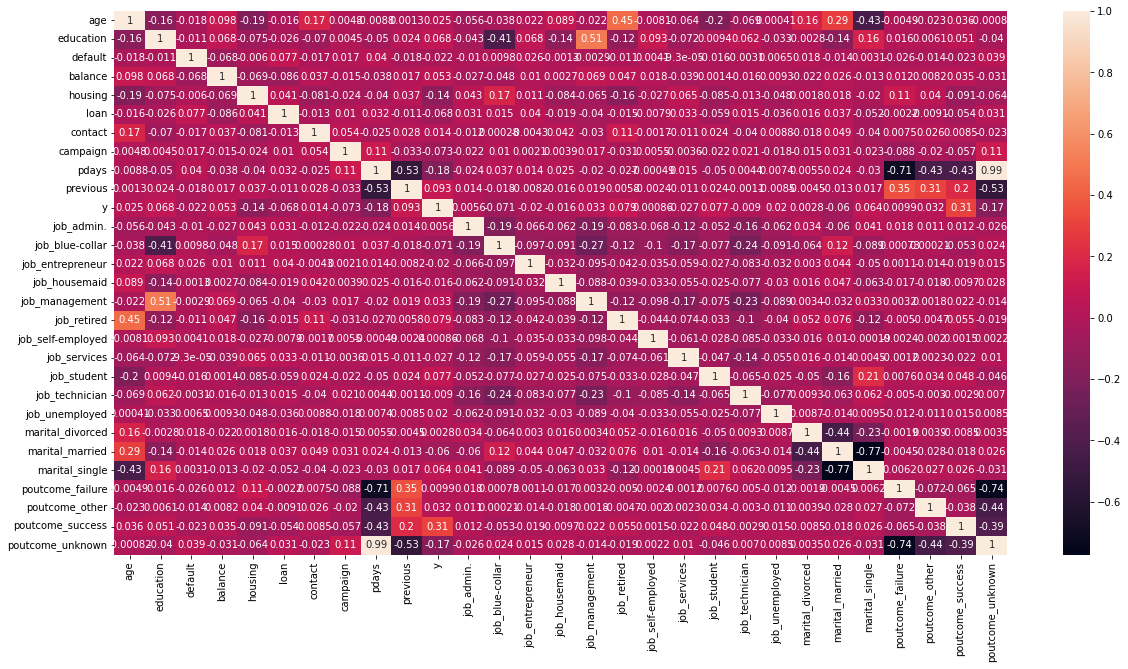

In [34]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(),annot = True)

In [44]:
train.corr().y.abs().sort_values()

job_self-employed    0.000855
marital_divorced     0.002772
job_admin.           0.005637
job_technician       0.008970
poutcome_failure     0.009885
contact              0.014042
job_housemaid        0.016126
job_entrepreneur     0.019662
job_unemployed       0.020390
default              0.022419
age                  0.025155
job_services         0.027489
poutcome_other       0.031955
job_management       0.032774
balance              0.053470
marital_married      0.060260
marital_single       0.063526
loan                 0.068185
education            0.068300
job_blue-collar      0.071222
campaign             0.073172
job_student          0.076897
job_retired          0.079245
previous             0.093236
housing              0.139173
poutcome_unknown     0.167051
pdays                0.178898
poutcome_success     0.306788
y                    1.000000
Name: y, dtype: float64

Seems like nothing highly correlated with subscribed column

# 3.Training :
Lets split the data

In [33]:
y = train.y.to_frame()
X = train.drop(columns = ["y"])
X_train , X_test , y_train , y_test = train_test_split(X,y, test_size = 0.25, random_state = 10)

**LogisticRegression**

In [34]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_predlr = lr.predict(X_test)
cmlr = confusion_matrix(y_test, y_predlr)
acclr = accuracy_score(y_test, y_predlr)
cmlr , acclr

/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(array([[9885,  107],
        [1101,  210]]),
 0.8931257188357073)

It's look like we have 90 percent accuracy.But this predictions quite wrong because our accuracy at positive predicted values is : 9885 / (9885 + 107) = 0.99 but our accuracy will be low at negative predicted values: 210 / (1101 + 210) = 0.16. This is happening because we did prediction at imbalanced dataset.Let's balance dataset with SMOTE

# 4.Data Augmentation

In [35]:
sm = SMOTE()
X_sm , y_sm = sm.fit_resample(X, y)
y_sm.y.value_counts()

0    39922
1    39922
Name: y, dtype: int64

# 5.Traning after SMOTE
Data balanced

In [38]:
from sklearn.model_selection import cross_val_score
results = []
X_train_sm , X_test_sm , y_train_sm , y_test_sm = train_test_split(X_sm,y_sm, test_size = 0.25, random_state = 10)
lr2 = LogisticRegression()
lr2.fit(X_train_sm,y_train_sm)
y_predlr2 = lr2.predict(X_test_sm)
cmlr2 = confusion_matrix(y_test_sm, y_predlr2)
acclr2 = accuracy_score(y_test_sm, y_predlr2)
results.append(cross_val_score(lr2, X_train_sm, y_train_sm, cv=5))
cmlr2 , acclr2

/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ),

(array([[7137, 2825],
        [2971, 7028]]),
 0.7096337858824708)

This time our accuracy around 72 percent. But as you can see our prediction improved at Specificty in confusion matrix.

Support Vector Classifier

In [40]:
svc = SVC()
svc.fit(X_train_sm, y_train_sm)
y_predsvc = svc.predict(X_test_sm)
cmsvc = confusion_matrix(y_test_sm, y_predsvc)
accsvc = accuracy_score(y_test_sm, y_predsvc)
results.append(cross_val_score(svc, X_train_sm, y_train_sm, cv=5))
cmsvc , accsvc

/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

(array([[8392, 1570],
        [6409, 3590]]),
 0.6002705275286809)

In [41]:
knn = KNeighborsClassifier()
knn.fit(X_train_sm, y_train_sm)
y_predknn = knn.predict(X_test_sm)
cmknn = confusion_matrix(y_test_sm, y_predknn)
accknn = accuracy_score(y_test_sm, y_predknn)
results.append(cross_val_score(knn, X_train_sm, y_train_sm, cv=5))
cmknn , accknn

/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

(array([[7134, 2828],
        [ 985, 9014]]),
 0.8089775061369671)

In [42]:
rf = RandomForestClassifier()
rf.fit(X_train_sm, y_train_sm)
y_predrf = rf.predict(X_test_sm)
cmrf = confusion_matrix(y_test_sm, y_predrf)
accrf = accuracy_score(y_test_sm, y_predrf)
results.append(cross_val_score(rf, X_train_sm, y_train_sm, cv=5))
cmrf , accrf

/tmp/ipykernel_31456/954633603.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_sm, y_train_sm)
/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/dhiraj/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

(array([[8780, 1182],
        [1382, 8617]]),
 0.8715495215670558)

In [44]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(n_estimators=150, random_state=0)
ada_clf.fit(X_train_sm, y_train_sm)
y_predada_clf = ada_clf.predict(X_test_sm)
cmada_clf = confusion_matrix(y_test_sm, y_predada_clf)
acc_adaclf = accuracy_score(y_test_sm, y_predada_clf)
results.append(cross_val_score(ada_clf, X_train_sm, y_train_sm, cv=5))
cmada_clf , acc_adaclf

(array([[8382, 1580],
        [2401, 7598]]),
 0.8005610941335605)

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
graclf = GradientBoostingClassifier(n_estimators=150, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_sm, y_train_sm)
y_pred_graclf = graclf.predict(X_test_sm)
cm_graclf = confusion_matrix(y_test_sm, y_pred_graclf)
acc_graclf = accuracy_score(y_test_sm, y_pred_graclf)
results.append(cross_val_score(graclf, X_train_sm, y_train_sm, cv=5))
cm_graclf , acc_graclf

(array([[8438, 1524],
        [2461, 7538]]),
 0.8003607033715746)

In [46]:
from sklearn.naive_bayes import CategoricalNB
gnb = CategoricalNB()
gnb.fit(X_train_sm, y_train_sm)
y_pred_gnb = gnb.predict(X_test_sm)
cm_gnb = confusion_matrix(y_test_sm, y_pred_gnb)
acc_gnb = accuracy_score(y_test_sm, y_pred_gnb)
results.append(cross_val_score(gnb, X_train_sm, y_train_sm, cv=5))
cm_gnb , acc_gnb

(array([[8238, 1724],
        [4052, 5947]]),
 0.7106357396924001)

In [83]:
len(X_test_sm.columns)

28

In [81]:
from tensorflow import keras
from tensorflow.keras import layers

In [87]:
ann = keras.Sequential([
  keras.layers.Dense(1024, input_shape=(28,), activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(8, activation='relu'),
  keras.layers.Dense(4, activation='relu'),
  keras.layers.Dense(2, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid'),
])

ann.compile(optimizer='adam', loss = keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

ann.fit(X_train_sm, y_train_sm, epochs=10, batch_size=8)

Epoch 1/10
7486/7486 [==============================] - 24s 3ms/step - loss: 0.6932 - accuracy: 0.5020
Epoch 2/10
7486/7486 [==============================] - 28s 4ms/step - loss: 0.6932 - accuracy: 0.4951
Epoch 3/10
7486/7486 [==============================] - 29s 4ms/step - loss: 0.6932 - accuracy: 0.4987
Epoch 4/10
7486/7486 [==============================] - 33s 4ms/step - loss: 0.6932 - accuracy: 0.5024
Epoch 5/10
7486/7486 [==============================] - 30s 4ms/step - loss: 0.6932 - accuracy: 0.4974
Epoch 6/10
7486/7486 [==============================] - 30s 4ms/step - loss: 0.6932 - accuracy: 0.5021
Epoch 7/10
7486/7486 [==============================] - 29s 4ms/step - loss: 0.6932 - accuracy: 0.4998
Epoch 8/10
7486/7486 [==============================] - 28s 4ms/step - loss: 0.6932 - accuracy: 0.4999
Epoch 9/10
7486/7486 [==============================] - 29s 4ms/step - loss: 0.6932 - accuracy: 0.5001
Epoch 10/10
7486/7486 [==============================] - 29s 4ms/step - l

In [61]:
results[-1]

array([       nan,        nan,        nan, 0.71200735, 0.71442886])

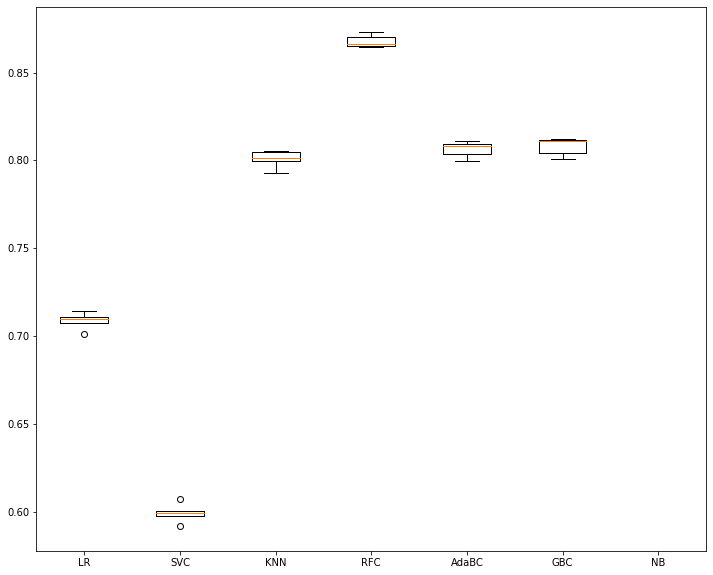

In [59]:
import matplotlib.pyplot as plt

names = ["LR", "SVC", "KNN","RFC", "AdaBC", "GBC", "NB"]

fig = plt.figure(figsize=(12,10))
ax=plt.axes()
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

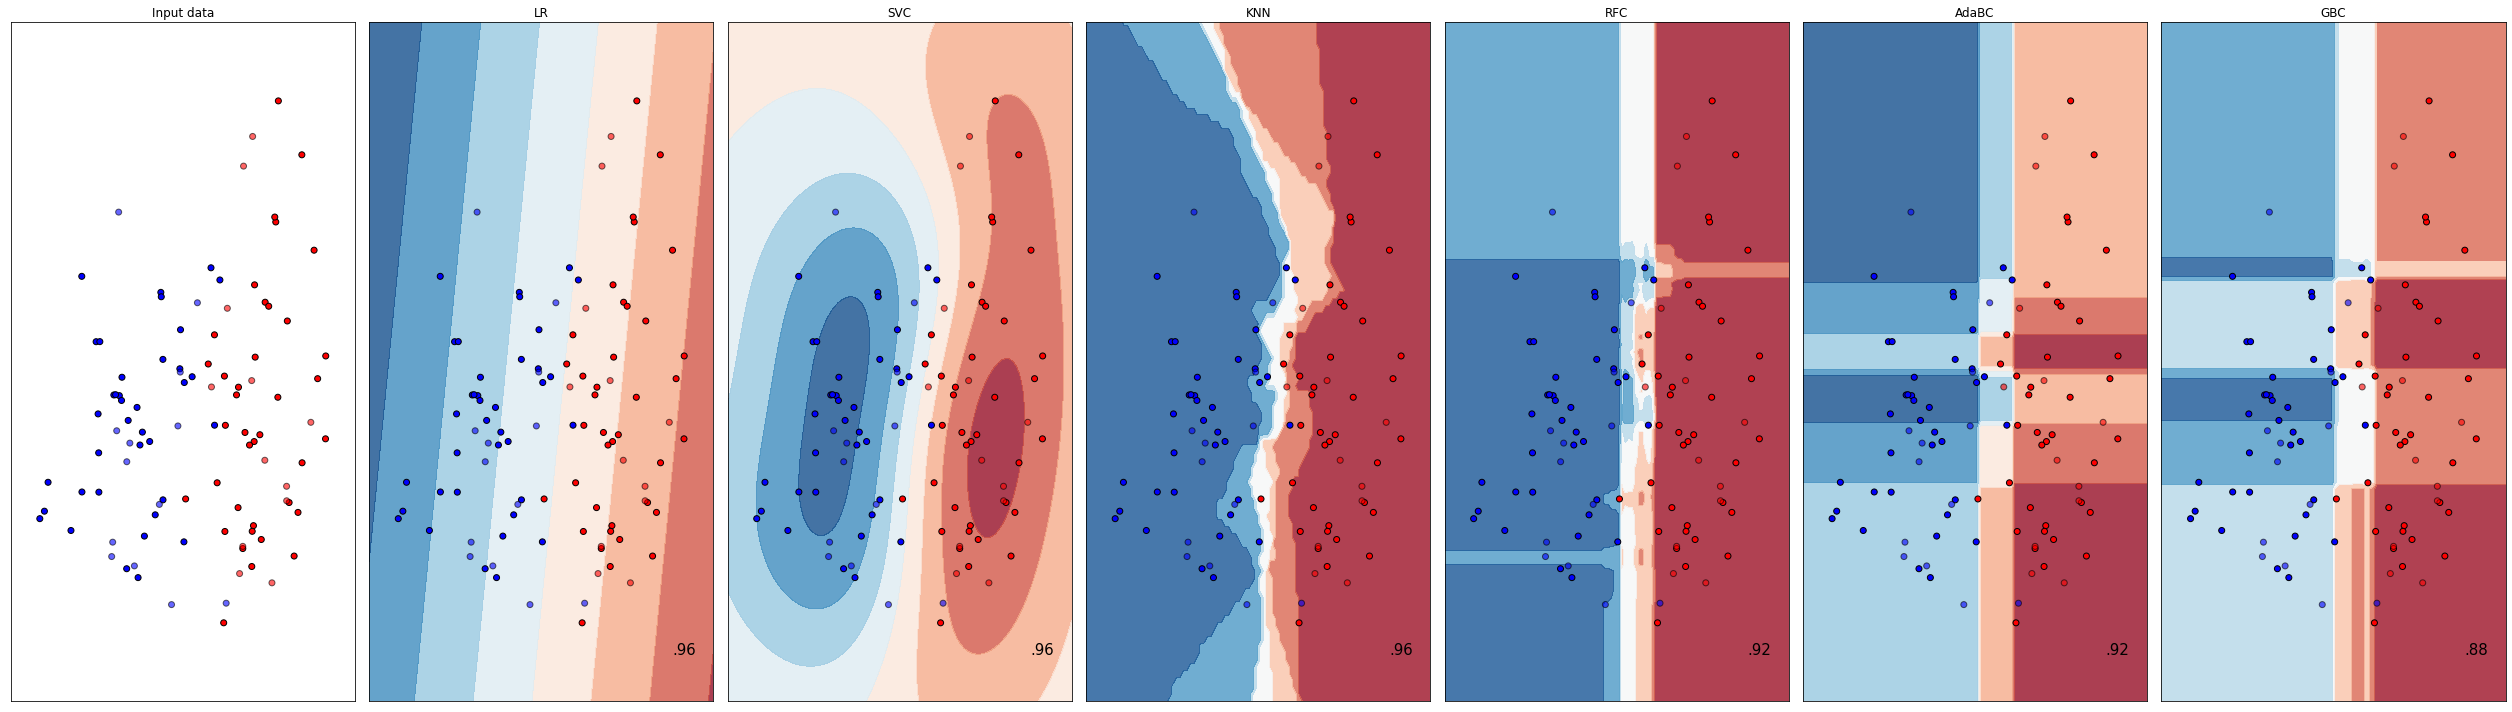

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

names = ["LR", "SVC", "KNN","RFC", "AdaBC", "GBC"]

classifiers = [
    LogisticRegression(),
    SVC(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(n_estimators=150, random_state=0),
    GradientBoostingClassifier(n_estimators=150, learning_rate=1.0, max_depth=1, random_state=0),
]

datasets = [
    train,
]

figure = plt.figure(figsize=(35, 10), facecolor="white")
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()
